In [180]:
import numpy as np
import scipy.sparse.linalg as spla
import scipy.sparse as sparse

class SoftInput():
    def __init__(self, X):
        self.X = X
        self.nonzero = self.X.nonzero()
        
    def fit(self, lambdas, maxiter=np.inf, tol=1e-6, start_rank=100):
        self.rank = start_rank
        self.tol = tol
        self.lambdas = np.sort(lambdas)[::-1]
        self.Z_proj = sparse.csr_matrix(self.X.shape)
        self.S = np.zeros((self.rank,))
        self.U = np.zeros((self.X.shape[0], self.rank))
        self.Vt = np.zeros((self.rank, self.X.shape[1]))
        
        self.U_approx = []
        self.Vt_approx = []
        
        for l in self.lambdas:
            num_iter = 0
            while (num_iter < maxiter):
                self.update_Z_proj()
                
                lin_op = spla.LinearOperator(self.X.shape,
                                             matvec=self.matvec,
                                             rmatvec=self.rmatvec)
                U, S, Vt = spla.svds(lin_op, self.rank)
                
                S -= l
                S[S < 0] = 0
                
                if (num_iter > 0):
                    rel_err = np.linalg.norm(S - self.S) ** 2 / np.linalg.norm(self.S) ** 2
                else:
                    rel_err = 2 * self.tol
                
                S = S[S > 0]
                self.rank = S.shape[0]
                
                U = U[:, :self.rank]
                Vt = Vt[:self.rank, :]
                
                self.U = U
                self.Vt = Vt
                self.S = S
                
                self.Vt = np.diag(self.S).dot(self.Vt)
                
                if (rel_err < self.tol):
                    print('converged with %e' %(rel_err))
                    break
                
                num_iter += 1
                
            self.U_approx.append(self.U)
            self.Vt_approx.append(self.Vt)
        
        return self.lambdas, self.U_approx, self.Vt_approx
    
    def update_Z_proj(self):
        proj_data = np.empty(self.nonzero[0].size)
        for i in range(self.nonzero[0].size):
            proj_data[i] = self.U[self.nonzero[0][i], :].dot(self.Vt[:, self.nonzero[1][i]])
        self.Z_proj = sparse.csr_matrix((proj_data, self.nonzero), self.X.shape)
            

    def matvec(self, vec):
        res = self.X.dot(vec) - self.Z_proj.dot(vec)
        res += self.U.dot(self.Vt.dot(vec))
        return res
    
    def rmatvec(self, vec):
        res = self.X.T.dot(vec) - self.Z_proj.T.dot(vec)
        res += self.Vt.T.dot(self.U.T.dot(vec))
        return res


In [181]:
# diagonal init
diags = np.arange(-5, 6, 10)
X = sparse.diags(diagonals=np.ones(diags.size), offsets=diags, shape=(100, 100))
X

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 190 stored elements (2 diagonals) in DIAgonal format>

In [182]:
# random init
np.random.seed(25)
row_ind = np.random.randint(0, 100, size=1000)
col_ind = np.random.randint(0, 100, size=1000)

row_ind = np.append(row_ind, np.arange(100))
col_ind = np.append(col_ind, np.arange(100))

X = sparse.csr_matrix((np.ones(row_ind.size), (row_ind, col_ind)), shape=(100, 100))

X[X > 1] = 1

In [183]:
soft_input = SoftInput(X)

In [184]:
np.seterr(all='raise')

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

In [186]:
lambdas = np.linspace(0, 0.5, 10)
print(lambdas)
lambdas, U, Vt = soft_input.fit(lambdas=lambdas, maxiter=200, start_rank=50, tol=1e-6)

[ 0.          0.05555556  0.11111111  0.16666667  0.22222222  0.27777778
  0.33333333  0.38888889  0.44444444  0.5       ]
converged with 7.856845e-07
converged with 6.555019e-07


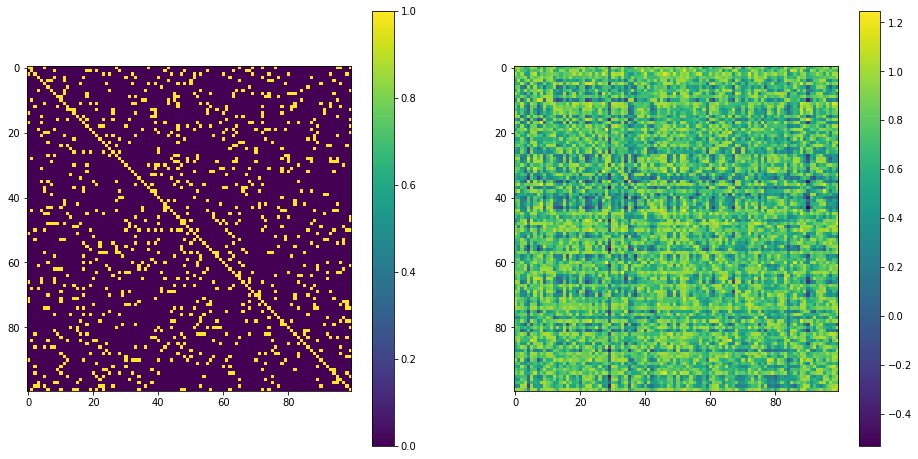

In [187]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
plt.imshow(U[-1].dot(Vt[-1]))
plt.colorbar()
plt.show()

In [142]:
np.linalg.matrix_rank(approximations[-1])

15

## Block matrix example ##

In [143]:
import matplotlib.pyplot as plt
from PIL import Image

In [144]:
img = np.array(Image.open('test.png'), dtype=np.float64)[:, :, 0]

In [145]:
img[img == 0] = 100

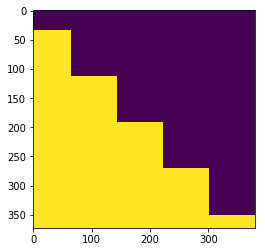

In [146]:
plt.imshow(img)
plt.show()

In [147]:
rows = np.array([], dtype=np.int)
cols = np.array([], dtype=np.int)

k_vals = np.array([-100, -50, -25, -10, -5, 0, 5, 10, 25, 50, 100, 1, 2, 3, -1, -2, -3], dtype=np.int)

for k in k_vals:
    A = sparse.eye(m=img.shape[0], n=img.shape[1], k=k)
    rows_ind, cols_ind = A.nonzero()
    rows = np.append(rows, rows_ind)
    cols = np.append(cols, cols_ind)
    
X = sparse.csr_matrix((img[(rows, cols)], (rows, cols)), shape=img.shape)

In [148]:
X[X == 100]

matrix([[ 100.,  100.,  100., ...,  100.,  100.,  100.]])

In [149]:
# random init
num = img.size // 10

np.random.seed(25)
row_ind = np.random.randint(0, img.shape[0], size=num)
col_ind = np.random.randint(0, img.shape[1], size=num)

row_ind = np.append(row_ind, np.arange(100))
col_ind = np.append(col_ind, np.arange(100))

X = sparse.csr_matrix((img[(row_ind, col_ind)], (row_ind, col_ind)), shape=img.shape)

for i in range(1, 5):
    X[X == 100 * i] = 100
    X[X == 255 * i] = 255

In [150]:
X.max()

255.0

In [151]:
soft_input = SoftInput(X)

In [152]:
lambdas = np.linspace(0, 100, 10)
print(lambdas)
lambdas, approximations = soft_input.fit(lambdas=lambdas, maxiter=2000, start_rank=100, tol=1e-6)

[   0.           11.11111111   22.22222222   33.33333333   44.44444444
   55.55555556   66.66666667   77.77777778   88.88888889  100.        ]
converged with 8.116713e-07
converged with 6.484353e-07
converged with 9.563193e-07
converged with 8.361490e-07
converged with 6.357105e-07
converged with 9.898027e-07
converged with 6.700713e-07


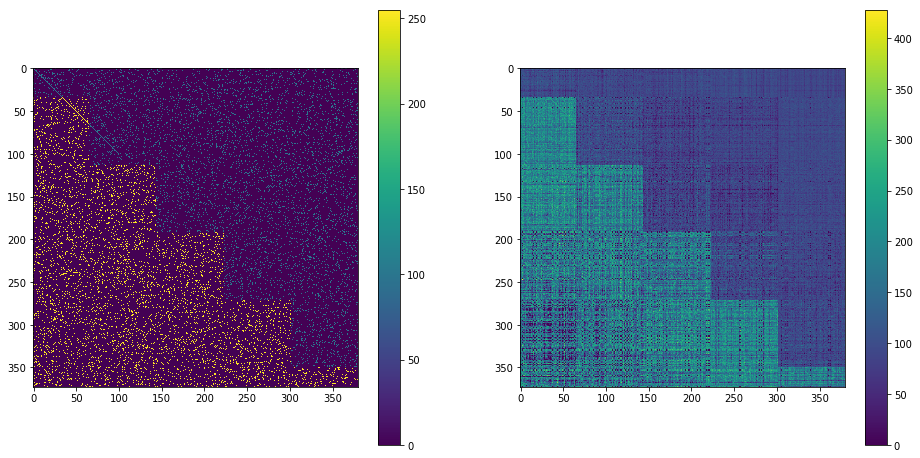

In [154]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
A = approximations[-1].copy()
A[A < 0] = 0 
plt.imshow(A)
plt.colorbar()
plt.show()

In [155]:
np.linalg.matrix_rank(approximations[0])

60

## Building example##

In [156]:
import matplotlib.pyplot as plt
from PIL import Image

In [157]:
img = np.array(Image.open('sk.png'), dtype=np.float64)[:, :, 0]

In [158]:
img[img == 0] = 100

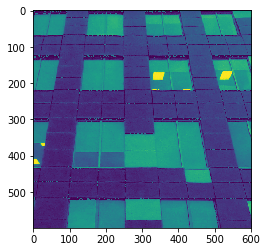

In [159]:
plt.imshow(img)
plt.show()

In [160]:
# random init
num = img.size // 10

np.random.seed(25)
row_ind = np.random.randint(0, img.shape[0], size=num)
col_ind = np.random.randint(0, img.shape[1], size=num)

row_ind = np.append(row_ind, np.arange(100))
col_ind = np.append(col_ind, np.arange(100))

X = sparse.csr_matrix((img[(row_ind, col_ind)], (row_ind, col_ind)), shape=img.shape)

for i in range(1, 5):
    X[X == 100 * i] = 100
    X[X == 255 * i] = 255

In [161]:
X.max()

506.0

In [162]:
soft_input = SoftInput(X)

In [163]:
lambdas = np.linspace(0, 100, 10)
print(lambdas)
lambdas, approximations = soft_input.fit(lambdas=lambdas, maxiter=2000, start_rank=100, tol=1e-6)

[   0.           11.11111111   22.22222222   33.33333333   44.44444444
   55.55555556   66.66666667   77.77777778   88.88888889  100.        ]
converged with 9.854360e-07
converged with 8.231251e-07
converged with 7.028571e-07
converged with 6.078505e-07
converged with 5.516236e-07
converged with 5.333856e-07
converged with 5.496171e-07
converged with 5.987079e-07
converged with 6.822732e-07
converged with 8.071253e-07


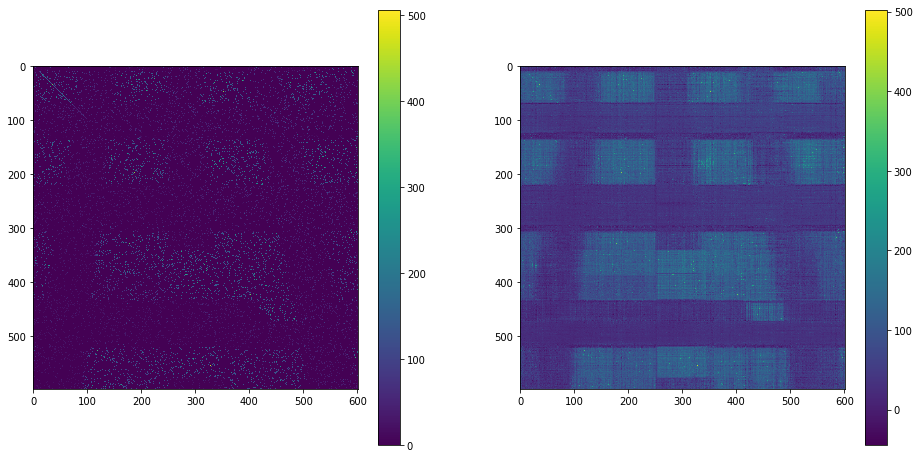

In [164]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
plt.imshow(approximations[-1])
plt.colorbar()
plt.show()

In [165]:
np.linalg.matrix_rank(approximations[0])

93